# Generalized coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

## Definition
For the linear models of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $\tilde{x}_{t+1}$ is the $n$-dimentional state at time $t+dt$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

Here, A will be the following matrix:  

$$ A = 
\begin{bmatrix}
1 & dt & \frac{dt^2}{2} & \cdots & \frac{dt^n}{n!}\\
0 & 1 & dt & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & 1 & dt \\
0 & \cdots & \cdots & \cdots & 1-\frac{dt\beta}{m}
\end{bmatrix}
\textbf{ }\textbf{ }\textbf{ }\textbf{ }and\textbf{ }\textbf{ }\textbf{ }\textbf{ }
B = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ \frac{dt}{m}\end{bmatrix}
$$  
  
We choose this matrix since, according to the Taylor's formula:  
$ x\left (t+dt \right) = x\left (t \right) + dt\times \dot{x}\left (t \right) + \frac{dt^2}{2}\times \ddot{x}\left (t \right)+ \dots + \frac{dt^n}{n!}\times x^{(n)}\left (t \right) + \mathcal{o}\left(dt^n\right)
$
and  
$x^{(n)}\left (t+dt \right) = \left ( 1 - \frac{dt\beta}{m} \right)x^{(n)}\left (t \right) + \frac{dt}{m}\left (u \left (t\right) + w\left (t\right) \right)
$

In [3]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [117]:
beta = 50 
m = 1
dt = 0.0025 # step time
n = 2 # number of coordinates
k = 0.0005 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing

In [118]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt*beta/m
B[n-1] = dt/m

In [119]:
t_T = .05 # movement duration
t_R = .05 # post-movement duration
T = int(t_T/dt)
R = int(t_R/dt)
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = 10

## Mean and covariance matrix
$\tilde{x}_t = A\tilde{x}_{t-1}+B\left (u_{t-1}+w_{t-1} \right) \\
\tilde{x}_t = A \left (A\tilde{x}_{t-2}+B\left (u_{t-2}+w_{t-2} \right)\right) + B\left (u_{t-1}+w_{t-1} \right) \\
...\\
\tilde{x}_t = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}B \left (u_i+w_i \right)}
$
  
We deduce the mean:
$E\left [\tilde{x}_t \right] = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}Bu_i}$ since $E\left [w_t \right] = 0$.


Then, $cov\left [\tilde{x}_t\right ] = \sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T E\left [w_t^2 \right]} = k\sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T u_t^2}$


  
## Minimum-variance problem
Here, the problem we consider consists in minimizing the sum of the variance of the position after reaching the target. Let $V_t$ be the top-left value in the covariance matrix at time $t$. Then, we want to minimize $\sum \limits_{t=T+1}^{T+R}V_t +bias$. 

In [120]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])

In [121]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return (ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

In [122]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return (m**2)*k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

In [123]:
mult_v = np.array([1, 0.01]) # we select the level of each parameter in the cost function

In [124]:
def bias(u, t):
    """Computation of the bias of the state vector at time t, given u
    """
    return (((expectation(u, t)-xT)**2)*mult_v).sum()

 
This can be formulated as a quadratic programming problem, which we solved using a gradient descent.

## Gradient descent

Let $\mathscr{C}$ be the cost function to minimize.  
That is, we want to find $\textbf{u}_{\textbf{opt}} = \underset{u_0, ..., u_{T+R}}{argmin} \left (\sum \limits_{t=T+1}^{T+R}V_t  + \sum \limits_{t=T}^{T+R}\|E\left [\tilde{x}_t\right] - x_T \|^2 \right )= \underset{u_0, ..., u_{T+R}}{argmin}\left(\mathscr{C}\left (\textbf{u}\right)\right)$.



In [125]:
def cost(u):
    def var1d(t):
        return(variance(u,t))
    var_vec = np.vectorize(var1d)
    def bias1d(t):
        return(bias(u,t))
    bias_vec = np.vectorize(bias1d)
    return var_vec(T+1+np.arange(R)).sum() + bias_vec(T+np.arange(R+1)).sum()

Iterating the following process, we will get the right $\textbf{u}_{\textbf{opt}}$ :  
$\forall i \in \left \{ 0, ..., T+R-1 \right \} : u_i = u_i - \eta \times \frac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i}$

In [126]:
def cost_deriv(u, i):
    """Derivative of the cost function with respect to u_i
    """
    if i < T:
        return (2*np.transpose(ci[:,(T-i-1):(T+R-i)])*np.array(([expectation(u,t).tolist() for t in (T+np.arange(R+1))])-xT)*mult_v).sum() + 2*(m**2)*k*u[i]*(ci0_array[(T+1-i-1):(T+R-i)]**2).sum()
    elif i == T:
        return (2*np.transpose(ci[:,0:R])*([expectation(u,t).tolist() for t in (T+1+np.arange(R))]-xT)*mult_v).sum() + 2*(m**2)*k*u[T]*(ci0_array[0:R]**2).sum()
    else:
        return (2*np.transpose(ci[:,0:(T+R-i)])*([expectation(u,t).tolist() for t in (i+1+np.arange(R+T-i))]-xT)*mult_v).sum() + 2*(m**2)*k*u[i]*(ci0_array[0:(T+R-i)]**2).sum()

In [152]:
niter = 500000
eta = 200000

In [153]:
import time

In [156]:
ubang = np.array([ 19662.047045,  19662.047045,  19662.047045,  19662.047045,
        19662.047045,  19662.047045,  19662.047045,  19662.047045,
        19662.047045,  19662.047045,  19662.047045,  19662.047045,
        19662.047045,  19662.047045,  19662.047045, -19662.047045,
       -19662.047045, -19662.047045, -19662.047045, -19662.047045,
            0.      ,      0.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ,      0.      ,      0.      ])

In [155]:
#np.random.seed(42)
#u = np.random.uniform(-5, 5, T+R+1)
#u[T:T+R+1]=0
debut = time.time()
#u = 20000* np.ones(T+R+1)
#u[T-4:T] *= -3
#u[T:(T+R+1)] = 0
u = ubang.copy()
a = np.zeros((niter+1, T+R+1)) # To save the evolution of the values of u at each iteration
a[0, :] = u.copy()
for i_iter in np.arange(niter):
    u_old = u.copy()
    u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
    a[i_iter+1, :] = u.copy()
fin = time.time()

In [139]:
np.array([cost_deriv(u, i) for i in np.arange(T+R)])

array([ -1.45518553e-07,  -1.33182190e-07,  -1.19001858e-07,
        -1.02689432e-07,  -8.39082169e-08,  -6.22638140e-08,
        -3.72930584e-08,  -8.45057523e-09,   2.49075942e-08,
         6.35439679e-08,   1.08364018e-07,   1.60445953e-07,
         2.21077040e-07,   2.91797740e-07,   3.74455057e-07,
         4.71266436e-07,  -5.89353024e-07,  -3.86281440e-07,
        -1.55153509e-07,   1.07236680e-07,   9.05568065e-12,
        -5.33433614e-14,  -4.73107776e-14,  -4.24531439e-14,
        -3.76244516e-14,  -3.28175441e-14,  -2.80305682e-14,
        -2.32621957e-14,  -1.85083873e-14,  -1.37659023e-14,
        -9.03227857e-15,  -4.30359687e-15,   4.21646852e-16,
         5.14736502e-15,   9.87626241e-15,   1.46114199e-14,
         1.93557545e-14,   2.41121886e-14,   2.88835737e-14,
         3.36840028e-14])

In [26]:
fin-debut

254.69027757644653

In [20]:
u

array([  1.03425383e+04,   1.23048971e+04,   1.43890484e+04,
         1.65950572e+04,   1.89216676e+04,   2.13660855e+04,
        -2.40667407e+04,  -2.21111628e+04,  -1.99981048e+04,
        -1.77297619e+04,  -1.42801378e+01,  -3.60573378e-01,
        -3.57778842e-01,  -3.61466056e-01,  -3.66055555e-01,
        -3.71560177e-01,  -3.77993647e-01,  -3.85372035e-01,
        -3.93713814e-01,  -4.03011394e-01,   0.00000000e+00])

In [28]:
i_iter

99999

Then, we draw $\text{u}$, that is, the evolution of the control signal during the experiment.

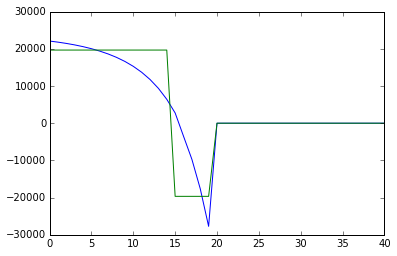

In [157]:
plt.plot(u)
plt.plot(ubang)

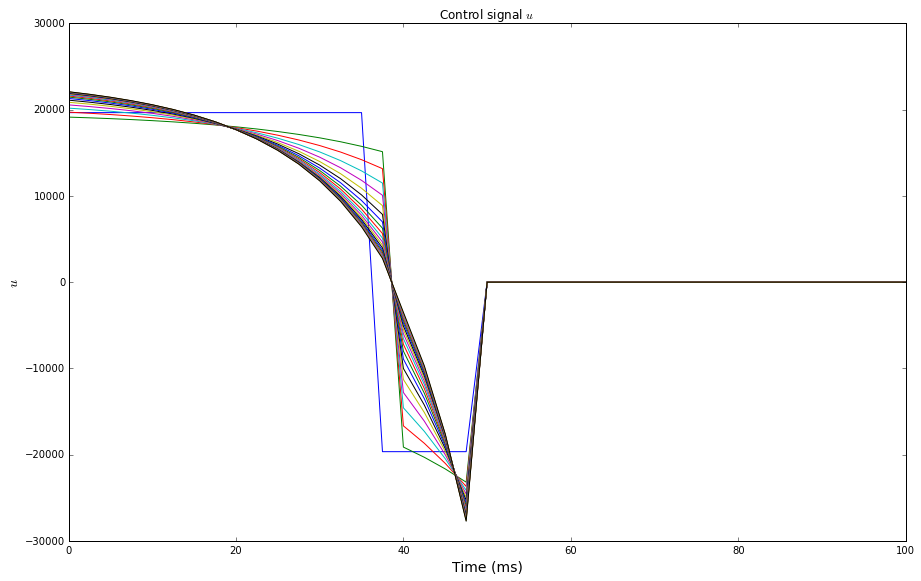

In [168]:
plot_signal(a, 25000, 500000, 0.05, 0.05, 0.0025)

In [160]:
position = np.zeros((niter+1,T+R+1))
velocity = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        mean = expectation(a[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]

In [169]:
position[0] = np.array([  0.        ,   0.05896178,   0.22651294,   0.48989389,
         0.83784434,   1.2604271 ,   1.74887265,   2.2954419 ,
         2.89330515,   3.53643519,   4.21951302,   4.93784467,
         5.68728769,   6.46418641,   7.26531469,   8.08691462,
         8.83033415,   9.37088202,   9.73239626,   9.93591389,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,  10.        ])

In [193]:
velocity[0] = np.array([   0.        ,   46.20702859,   86.98458819,  122.97065824,
        154.72825359,  182.75423312,  207.48707325,  229.31372806,
        248.57568332,  265.57429917,  280.57552501,  293.81406035,
        305.49702678,  315.80720847,  324.90591187,  331.42985723,
        255.10376287,  178.92125199,  111.6904221 ,   52.35942296,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,    0.        ])

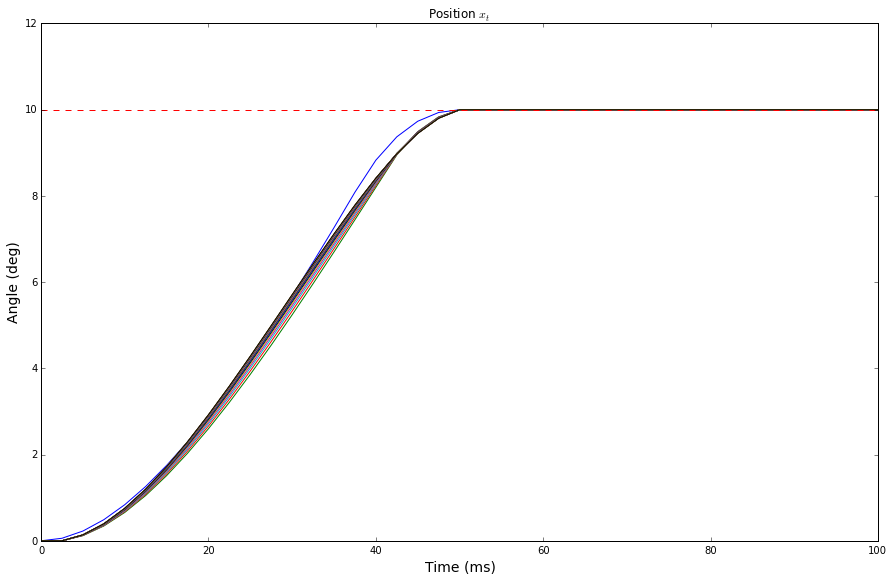

In [194]:
plot_position(position, 25000, 500000, 0.05, 0.05, 0.0025)
plt.plot([0,100],[10,10],'r--')
plt.plot([0,0],[11,11],'r--')


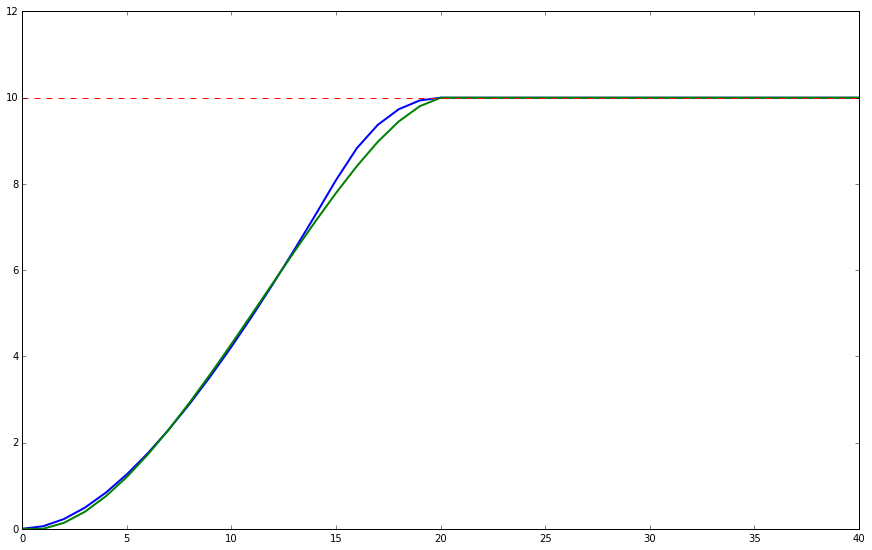

In [195]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(position[0], lw=2)
plt.plot(position[niter], lw=2)
plt.plot([0,40],[10,10],'r--')
plt.plot([0,0],[11,11],'r--')


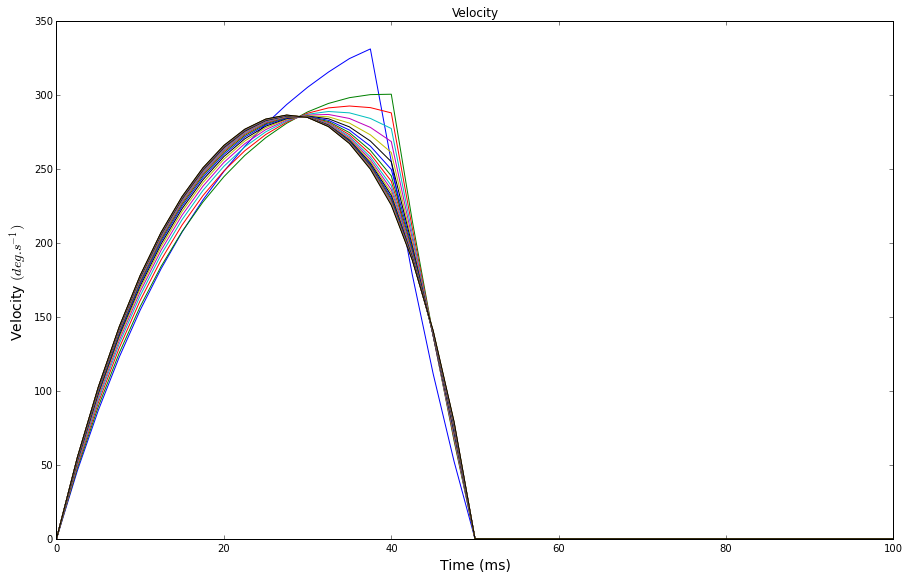

In [196]:
plot_velocity(velocity, 25000, 500000,  0.05, 0.05, 0.0025)

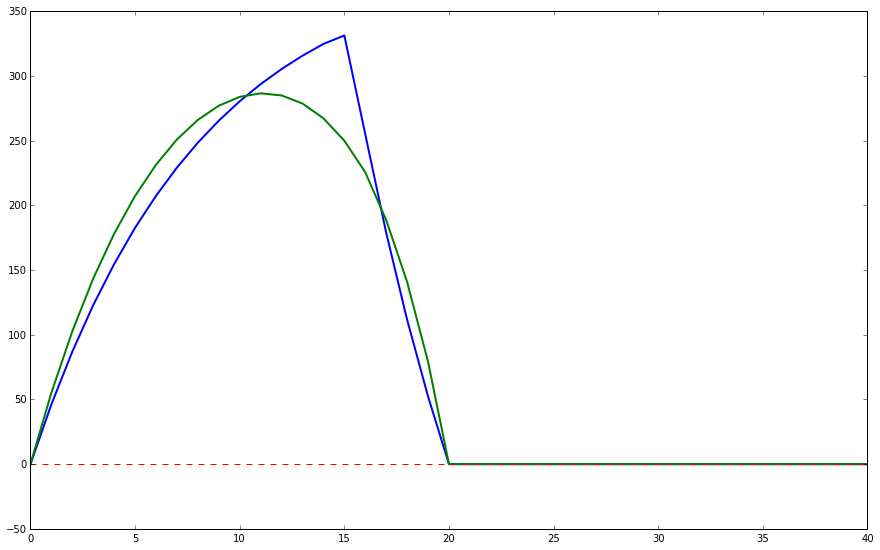

In [197]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(velocity[0], lw=2)
plt.plot(velocity[niter], lw=2)
plt.plot([0,40],[0,0],'r--')
plt.plot([0,0],[-1,-1],'r--')


In [182]:
variancev = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        variancev[i,j] = variance(a[i,:], j)

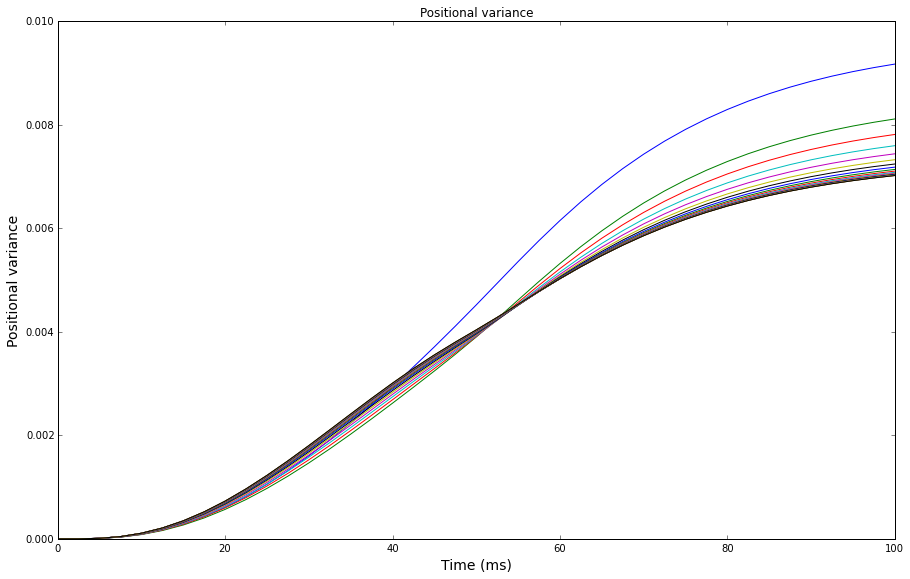

In [183]:
plot_variance(variancev, 25000, 500000, 0.05, 0.05, 0.0025)

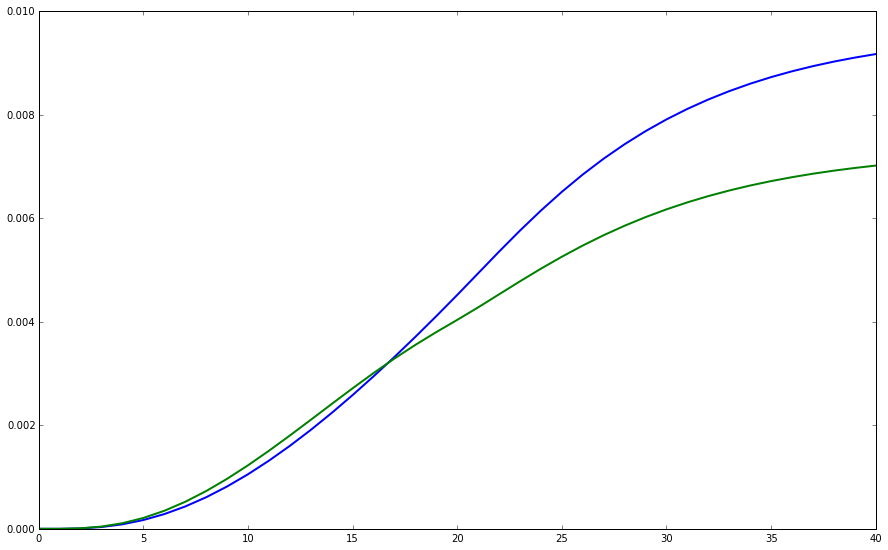

In [189]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(variancev[0], lw=2)
plt.plot(variancev[niter], lw=2)


In [198]:
cost_p = np.zeros(niter+1)

for i in np.arange(niter+1):
    cost_p[i] = cost(a[i])

In [199]:
np.argmin(cost_p)

500000

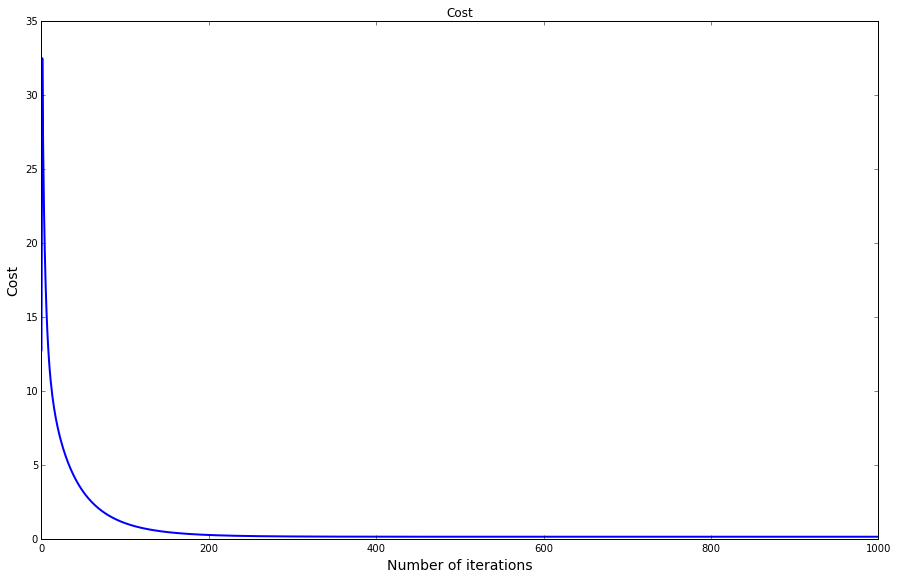

In [204]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(cost_p[0:1000], '-', lw = 2)
ax.set_title('Cost')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)


Finally, we trace the position at time T for each iteration.

In [205]:
positionT = np.zeros(niter+1)

for i in np.arange(niter+1):
    positionT[i] = (expectation(a[i], T))[0]

(0, 11)

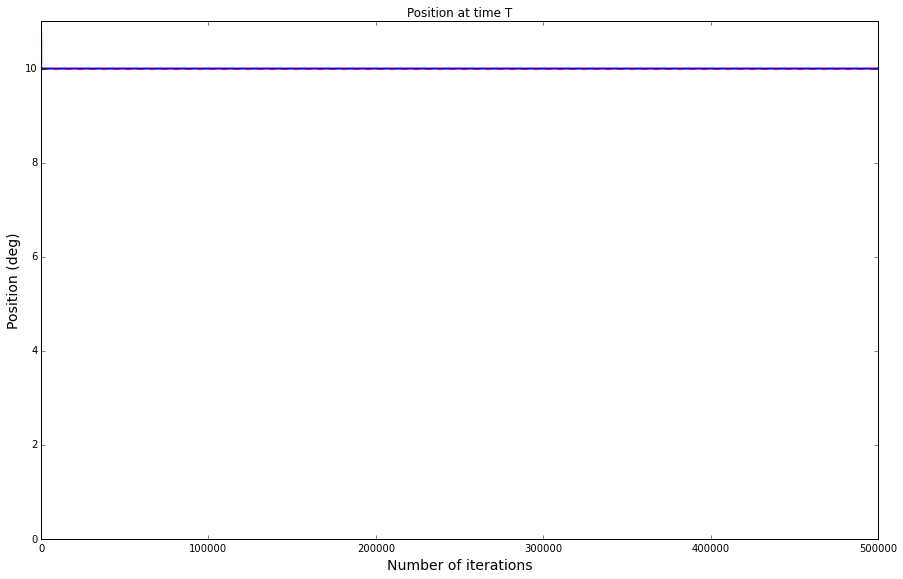

In [206]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(positionT, '-', lw=2)
ax.set_title('Position at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Position (deg)', fontsize=14)
ax.plot([0,niter],[10,10],'r--')
ax.set_ylim(0, 11)